In [2]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

In [3]:
DEVICE = 'cuda:0'

In [4]:
def model(params, sigma = .1):
    z = np.array(list(params.values()))
    x = np.abs(z-0.5)*2  # 0 ... 1
    return dict(x=x)

In [5]:
def noise(obs, params, sigma = 0.1):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [6]:
zdim=10
params = ["z"+str(i) for i in range(zdim)]
par0 = {k: 0.25 for k in params}
obs0 = noise(model(par0), par0)
obs1=model(par0)  # Asimov data

In [7]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in params})

In [8]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 1000, Nmax=20000)

Creating new cache.


In [9]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

NRE round: R = 1
Number of training samples is N_R = 1000
Additional simulations are required after growing the cache.
Simulate:   2%|▏         | 22/1031 [00:00<00:04, 213.00it/s]

  adding 1031 new samples to simulator cache.


Simulate: 100%|██████████| 1031/1031 [00:04<00:00, 208.83it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 13.86
validation loss = 13.45
validation loss = 11.77
validation loss = 10.49
validation loss = 9.685
validation loss = 9.03
validation loss = 8.618
validation loss = 8.704
lr: 0.0001
validation loss = 8.373
validation loss = 8.279
validation loss = 8.199
validation loss = 8.283
Train losses: [13.86195235416807, 13.741428079276249, 12.796271587240286, 11.363028427650189, 10.239399186496076, 9.69855417054275, 9.280766783089474, 8.671780915095889, 8.453198975530164, 8.410578102901065]
Valid losses: [13.856792132059732, 13.454998970031738, 11.77456251780192, 10.485563596089682, 9.684507052103678, 9.030306816101074, 8.618437131245932, 8.372800827026367, 8.27920150756836, 8.198531786600748]
Finished trainloop.
constr_prior_R : prior_R volume = 0.8241 : 1


In [10]:
samples = s.marginals(obs1, 10000)

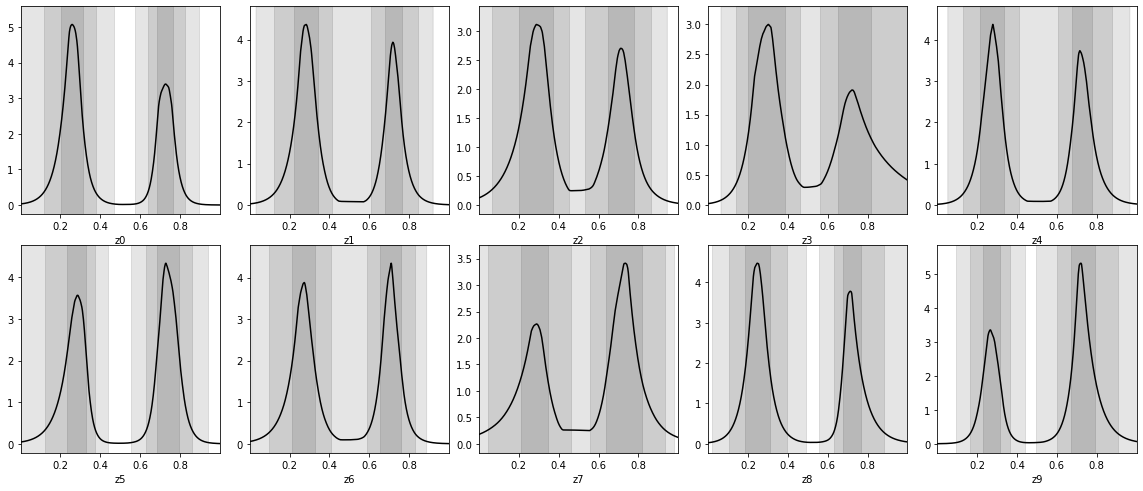

In [12]:
swyft.plot.plot1d(samples, params, figsize = (20, 8), ncol = 5, grid_interpolate = True)

In [ ]:
diags = []
for i in range(30):
    print(i)
    indices = s.cache.sample(s._history[-1]['constr_prior'], 300)
    points = swyft.Points(indices, s._cache, s._noise)
    for point in points:
        samples2 = s.marginals(point['obs'], 1000)
        diag = swyft.utils.sample_diagnostics(samples2, true_params = point['par'])
        diags.append(diag)
cont_mass = {key[0]: [v[key]['cont_mass'] for v in diags] for key in diag.keys()}
#swyft.plot.plot1d(samples2, params, figsize = (20, 8), ncol = 5, grid_interpolate = True, truth = point['par'])

0


In [ ]:
plt.hist(cont_mass['z4'], range = [0, 1], bins = 10);